<a href="https://colab.research.google.com/github/sukumr/Pothole-Detection-and-Segmentation/blob/main/MaskRCNN_Pothole_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MaskRCNN Pothole Segmentation

In [2]:
# To check the GPU
!nvidia-smi

Wed Feb 10 07:45:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Matterport Mask-RCNN in Google Colab

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
!pip3 uninstall -y keras
!pip3 install keras==2.1.5

Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 337kB 17.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [5]:
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
!pip3 install -r requirements.txt
!python3 setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 40.66 MiB/s, done.
Resolving deltas: 100% (561/561), done.
/content/Mask_RCNN
     |████████████████████████████████| 163kB 28.3MB/s 
     |████████████████████████████████| 204kB 49.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=5bfa2770bea21a8959f563b4cc1f27d8d295d1566fd6e3cbb1e799864523c391
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.

In [6]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 33.91 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/Mask_RCNN/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Mask_RCNN/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2

## Imports

In [7]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
print(ROOT_DIR)


# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 


# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/content


Using TensorFlow backend.


... done downloading pretrained model!


## Configurations

In [22]:
class Pothole_Config(Config):
    # Give the configuration a recognizable name
    NAME = "Pothole_segmentation"
    
    NUM_CLASSES = 1 + 1

    GPU_COUNT = 1

    IMAGES_PER_GPU = 1

    # Number of training steps per epoch
    # STEPS_PER_EPOCH = 500

config = Pothole_Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Dataset

In [9]:
# Mounting the drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [10]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'2-Test-MaskRCNN Pothole Segmentation.ipynb'   MRCNN
 Books					      'My Drive'
'Colab Notebooks'			       NN_verify.ipynb
 CS50					       Pothole
 events.out.tfevents.1612880849.b7ebf36d3882   yolov3
 images


In [11]:
# this is where my datasets are stored within my Google Drive
!ls /mydrive/Pothole

backup	    images.zip	pothole-2.zip	       pothole.zip
detect.zip  png		pothole_segmentation1  test


In [12]:
# copy over both datasets into the root directory of the Colab VM
!cp /mydrive/Pothole/pothole.zip ../

In [13]:
# unzip the datasets 
!unzip ../pothole.zip


Archive:  ../pothole.zip
   creating: test/
  inflating: test/img-599.jpg        
  inflating: test/img-599.json       
  inflating: test/img-661.jpg        
  inflating: test/img-661.json       
  inflating: test/img-627.jpg        
  inflating: test/img-627.json       
  inflating: test/img-655.jpg        
  inflating: test/img-655.json       
  inflating: test/img-625.jpg        
  inflating: test/img-625.json       
  inflating: test/img-613.jpg        
  inflating: test/img-613.json       
  inflating: test/img-604.jpg        
  inflating: test/img-604.json       
  inflating: test/img-654.jpg        
  inflating: test/img-654.json       
  inflating: test/img-611.jpg        
  inflating: test/img-611.json       
  inflating: test/img-607.jpg        
  inflating: test/img-607.json       
  inflating: test/img-640.jpg        
  inflating: test/img-640.json       
  inflating: test/img-617.jpg        
  inflating: test/img-617.json       
  inflating: test/img-619.jpg        
  infl

In [14]:
# Directory to save logs and trained model
MODEL_DIR = "/mydrive/Pothole/backup"
print(MODEL_DIR)

/mydrive/Pothole/backup


In [15]:
# Working directory
!pwd

/content


In [23]:
class PotholeDataset(utils.Dataset):
    def load_dataset(self, dataset_dir):
        self.add_class('dataset', 1, 'Pothole')
 
        # find all images
        for i, filename in enumerate(os.listdir(dataset_dir)):
            if '.jpg' in filename:
                self.add_image('dataset', 
                               image_id=i, 
                               path=os.path.join(dataset_dir, filename), 
                               annotation=os.path.join(dataset_dir, filename.replace('.jpg', '.json')))
    
    def extract_masks(self, filename):
        json_file = os.path.join(filename)
        with open(json_file) as f:
            img_anns = json.load(f)
            
        masks = np.zeros([600, 800, len(img_anns['shapes'])], dtype='uint8')
        classes = []
        for i, anno in enumerate(img_anns['shapes']):
            mask = np.zeros([600, 800], dtype=np.uint8)
            cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
            masks[:, :, i] = mask
            classes.append(self.class_names.index(anno['label']))
        return masks, classes
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        masks, classes = self.extract_masks(path)
        return masks, np.asarray(classes, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [17]:
# Create training and validation set
# train set
dataset_train = PotholeDataset()
dataset_train.load_dataset('train')
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))
 
# test/val set
dataset_val = PotholeDataset()
dataset_val.load_dataset('test')
dataset_val.prepare()
print('Test: %d' % len(dataset_val.image_ids))


Train: 300
Test: 72


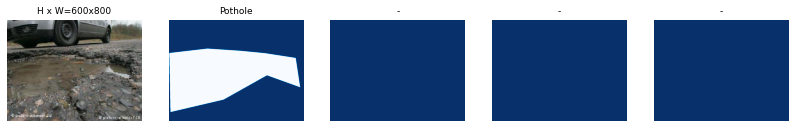

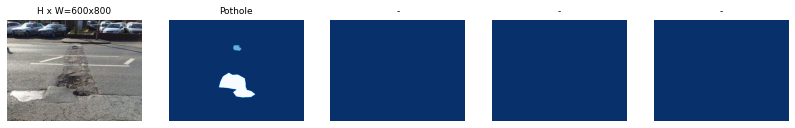

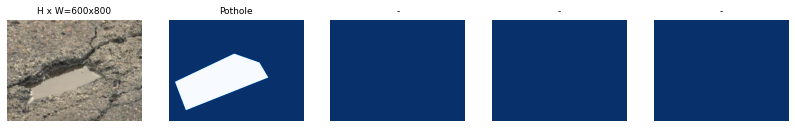

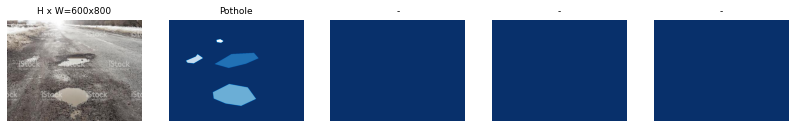

In [18]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [34]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [40]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
    
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

In [41]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /mydrive/Pothole/backup/pothole_segmentation20210210T1058/mask_rcnn_pothole_segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Ti

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 1.3701 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.4241 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.3858

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 642s 642ms/step - loss: 1.3703 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.4240 - mrcnn_class_loss: 0.1203 - mrcnn_bbox_loss: 0.3935 - mrcnn_mask_loss: 0.3860 - val_loss: 1.5747 - val_rpn_class_loss: 0.0671 - val_rpn_bbox_loss: 0.5654 - val_mrcnn_class_loss: 0.1680 - val_mrcnn_bbox_loss: 0.3967 - val_mrcnn_mask_loss: 0.3774
Epoch 2/10
1000/1000 [==============================] - 602s 602ms/step - loss: 1.0065 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.3192 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.3116 - val_loss: 1.4897 - val_rpn_class_loss: 0.0608 - val_rpn_bbox_loss: 0.4720 - val_mrcnn_class_loss: 0.1755 - val_mrcnn_bbox_loss: 0.3904 - val_mrcnn_mask_loss: 0.3909
Epoch 3/10
1000/1000 [==============================] - 600s 600ms/step - loss: 0.8255 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.2494 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.1774 - mrcnn_mask_loss: 0.2741 - val_loss: 1.6091 - val_rpn_cla

In [42]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.


model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=20, 
            layers="all")


Starting at epoch 10. LR=0.001

Checkpoint Path: /mydrive/Pothole/backup/pothole_segmentation20210210T1058/mask_rcnn_pothole_segmentation_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b  

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 11/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.6183 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2070 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.2017

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 1032s 1s/step - loss: 0.6182 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2070 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.2017 - val_loss: 1.4231 - val_rpn_class_loss: 0.0582 - val_rpn_bbox_loss: 0.5384 - val_mrcnn_class_loss: 0.1587 - val_mrcnn_bbox_loss: 0.2754 - val_mrcnn_mask_loss: 0.3924
Epoch 12/20
1000/1000 [==============================] - 965s 965ms/step - loss: 0.4707 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1748 - val_loss: 1.3556 - val_rpn_class_loss: 0.0923 - val_rpn_bbox_loss: 0.4669 - val_mrcnn_class_loss: 0.1555 - val_mrcnn_bbox_loss: 0.2770 - val_mrcnn_mask_loss: 0.3639
Epoch 13/20
1000/1000 [==============================] - 964s 964ms/step - loss: 0.3673 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1037 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.1511 - val_loss: 1.4530 - val_rpn_cla

## Detection

In [43]:
class InferenceConfig(Pothole_Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /mydrive/Pothole/backup/pothole_segmentation20210210T1058/mask_rcnn_pothole_segmentation_0020.h5
Re-starting from epoch 20


In [44]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  288.00000  max:  886.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


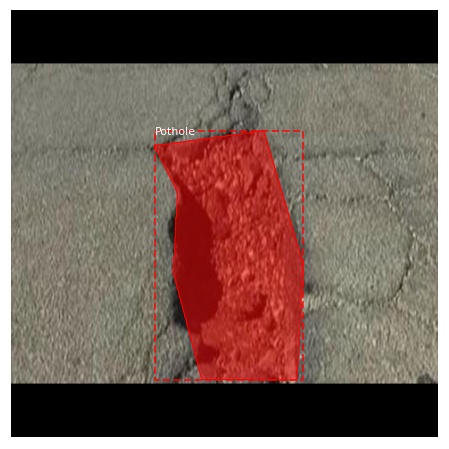

In [45]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  132.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


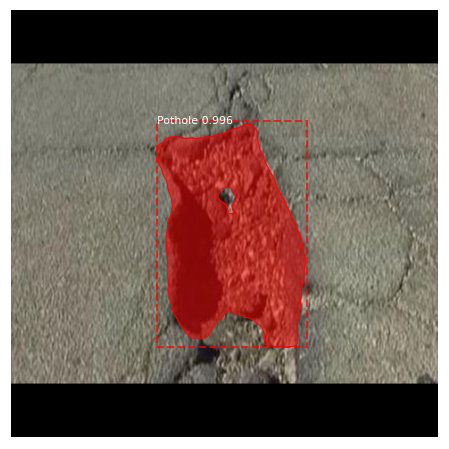

In [46]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [48]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7348013412400174
